# Model Tranning

In [2]:
# Import the required  Dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
full_df = pd.read_csv("../data/TripSafe_cleaned_Data.csv")
sample_df = pd.read_csv("../data/sample_TripSafe_cleaned_Data.csv")

# Removing extra columns
lst = ["Unnamed: 0","Zipcode"]
full_df = full_df.drop(lst, axis=1)


# Zipcode_Group_, City_ hold great importance
# Removing more columns, after a bit of running these columns have no impact on model_development performance
full_df = full_df.drop(columns=[col for col in full_df.columns if col.startswith("Weather_Condition_")])
full_df = full_df.drop(columns=[col for col in full_df.columns if col.startswith("Wind_Direction_")])
full_df = full_df.drop(columns=['Severity'])
sample_df = sample_df.drop(columns=[col for col in sample_df.columns if col.startswith("Weather_Condition_")])
sample_df = sample_df.drop(columns=[col for col in sample_df.columns if col.startswith("Wind_Direction_")])
sample_df = sample_df.drop(columns=['Severity'])


# Loading sample data
sample_df = sample_df.drop(lst,axis=1)
sample_df = sample_df.sample(n=10000,random_state=42)


print(full_df.shape)
print(sample_df.shape)


(1160100, 79)
(10000, 79)


In [3]:
full_df.dtypes

Temperature(F)         float64
Humidity(%)            float64
Pressure(in)           float64
Visibility(mi)         float64
Wind_Speed(mph)        float64
                        ...   
Zipcode_Group_956        int64
Zipcode_Group_958        int64
Zipcode_Group_959        int64
Zipcode_Group_Other      int64
Cluster                  int64
Length: 79, dtype: object

In [4]:
from backend.src.input_processing.date_data_extraction import DataExtractor
f = DataExtractor()

d =DataExtractor()
k =d.get_transformed_data("02/02/2016, 12:34","san Jose","santa clara","95377")
for p in k.columns:
    print(p)


   day_of_week  Hour  Month  Is_Holiday  Is_Rush_Hour  Temperature(F)  \
0            0     3      8           0             0            72.0   

   Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  Wind_Chill(F)  \
0           50         29.92              10                5           70.0   

   Precipitation(in)  City_san Jose  County_santa clara  Zipcode_Group_953  
0                0.0           True                True               True  
(1, 78)
   Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
0             0.0          0.0           0.0             0.0              0.0   

   Wind_Chill(F)  Precipitation(in)  Hour  day_of_week  Month  ...  \
0            0.0                0.0   0.0            0      8  ...   

   Zipcode_Group_946  Zipcode_Group_950  Zipcode_Group_951  Zipcode_Group_952  \
0                  0                  0                  0                  0   

   Zipcode_Group_953  Zipcode_Group_954  Zipcode_Group_956  Zip

Components with 80% variance: 5
Components with 85% variance: 6
Components with 90% variance: 9
Components with 95% variance: 14
Components with 96% variance: 17
Components with 98% variance: 27
Components with 99% variance: 37


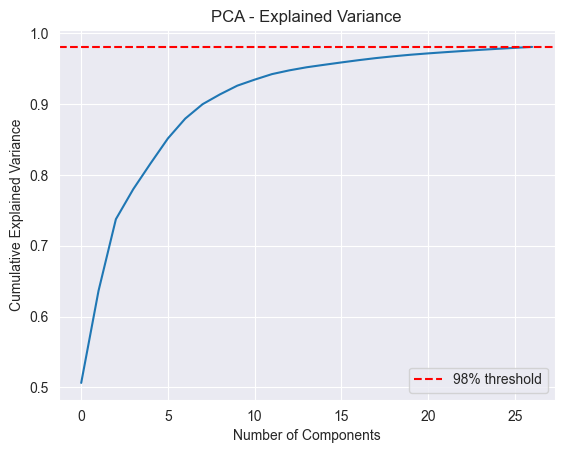

In [5]:
# Import the Required  Dependencies
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import numpy as np

# Preparation for training and feature selection 
X = sample_df.drop("Cluster",axis= 1)
y = sample_df["Cluster"]


# Principal Component Analysis - Is a way to shrink the dimensionality of the dataset
# PCA allows us to keep the most relevant feature only, we can either explicitly  mention the number of columns we want to keep or  give it percentage preserve the variance


#Splitng the data in test and train 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state= 30)


# Find the best percentage of data to keep while reducing the number of features

variance_list = [0.80,0.85,0.90,0.95,0.96,0.98,0.99]

for variance in variance_list:
    pca = PCA(variance)
    X_train_pca = pca.fit_transform(X_train)
    print(f"Components with {int(variance * 100)}% variance: {X_train_pca.shape[1]}")
    
# Keeping 98% percent of the variance
pca = PCA(0.98)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.axhline(y=0.98, color='r', linestyle='--', label='98% threshold')
plt.grid(True)
plt.legend()
plt.show()
 

In [6]:
# Import the Required  Dependencies
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import log_loss, classification_report

# Selecting Parameter for GridSearchCV
model_prams = {
    "svm": {
        'model_development': svm.SVC(probability=True),
        'params':{
             'C': [ 0.01, 0.1,1]
        }  
    },
    "randomForest":{
        'model_development': RandomForestClassifier(),
        'params':{
            'n_estimators': [10,20,50],
            'max_depth':[4,8,15]
        }
    },
    
    "logistic_regression":{
        'model_development': LogisticRegression(max_iter= 1000),
        'params': {
             'C': [ 0.01, 0.1,1]
        }
    }
}

scores =[]
best_estimators = {}
for algo, mp in model_prams.items():
    print(f"Training: {algo}")
    
    clf = GridSearchCV(mp["model_development"],mp["params"],cv=5, n_jobs=-1,return_train_score=True,  scoring='neg_log_loss')
    model =clf.fit(X_train,y_train)
    best_estimators[algo] = clf.best_estimator_
    
    
    
    y_pred = clf.predict(X_test)
    
    y_proba_train = clf.predict_proba(X_train)
    y_proba_test = clf.predict_proba(X_test)
    
    
    train_loss =log_loss(y_train,y_proba_train)
    test_loss =log_loss(y_test,y_proba_test)
    
    
    print(f"\n=== {algo.upper()} ===")
    print(f"Best Params: {clf.best_params_}")
    print(f"Best Params Train Loss:{train_loss}")
    print(f"Best Params Test Loss: {test_loss}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
   
    # Loss
    # Extract and convert to actual (positive) loss
    train_losses = -clf.cv_results_['mean_train_score']
    test_losses = -clf.cv_results_['mean_test_score']
    params = clf.cv_results_['params']

    
    for i in range(len(params)):
         print(f"Params: {params[i]}")
         print(f"→ Train Loss: {train_losses[i]:.4f}, Test Loss: {test_losses[i]:.4f}\n")


Training: svm

=== SVM ===
Best Params: {'C': 1}
Best Params Train Loss:0.08708390699584467
Best Params Test Loss: 0.10811244098572959
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       666
           1       0.94      1.00      0.97       681
           2       0.97      0.92      0.94       653

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000

Params: {'C': 0.01}
→ Train Loss: 0.7284, Test Loss: 0.7436

Params: {'C': 0.1}
→ Train Loss: 0.2546, Test Loss: 0.2633

Params: {'C': 1}
→ Train Loss: 0.0908, Test Loss: 0.0984

Training: randomForest

=== RANDOMFOREST ===
Best Params: {'max_depth': 15, 'n_estimators': 20}
Best Params Train Loss:0.12162215321406711
Best Params Test Loss: 0.14335103888823256
Classification Report:
              precision    recall  f1-score   support

           0       0.9

array([[666,   0,   0],
       [  0, 681,   0],
       [ 11,  39, 603]])

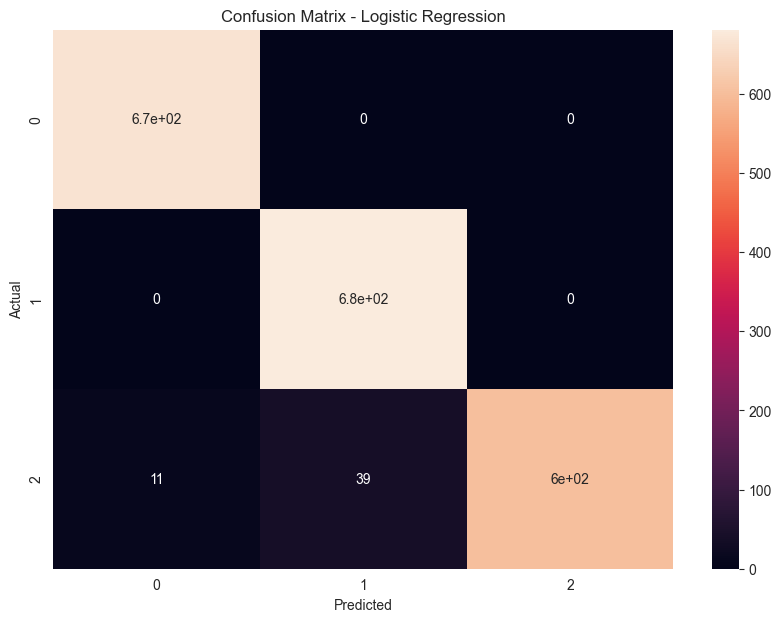

In [7]:
# Import the required  Dependencies
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Drawing Confusing Matrix
best_clf = best_estimators['randomForest']
cm = confusion_matrix(y_test, best_clf.predict(X_test))

# Plot
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot= True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')


cm

In [8]:
import joblib

X_final = full_df.drop("Cluster",axis= 1)
y_final  = full_df["Cluster"]

#Splitng the data in test and train 
X_train, X_test, y_train, y_test = train_test_split(X_final,y_final,test_size= 0.2,random_state= 30)

# Keeping 98% percent of the variance
pca = PCA(0.98)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Saving the pca model for live inference
joblib.dump(pca, "../models/pca_transformer.pkl")

# Initialize logistic regression model_development
model = best_estimators['logistic_regression']

# Define 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using cross-validation
scores = cross_val_score(model, X_train_pca, y_train, cv=kfold, scoring='accuracy')

# Print scores
print("Cross-validated scores:", scores)
print("Mean accuracy:", scores.mean())

# Now train on full training set and evaluate on test set
model.fit(X_train_pca, y_train)

y_pred_test = model.predict(X_test_pca)
y_pred_train = model.predict(X_train_pca)

# Classification report Test
print("\nClassification Report Test Set :\n", classification_report(y_test, y_pred_test))

# Classification report Test
print("\nClassification Report Train Set :\n", classification_report(y_train, y_pred_train))




Cross-validated scores: [0.95918994 0.95889902 0.96008426 0.95846802 0.95646388]
Mean accuracy: 0.9586210240496509

Classification Report Test Set :
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     77158
           1       0.94      0.98      0.96     77709
           2       0.97      0.92      0.94     77153

    accuracy                           0.96    232020
   macro avg       0.96      0.96      0.96    232020
weighted avg       0.96      0.96      0.96    232020


Classification Report Train Set :
               precision    recall  f1-score   support

           0       0.98      0.99      0.98    309542
           1       0.94      0.98      0.96    308991
           2       0.97      0.92      0.94    309547

    accuracy                           0.96    928080
   macro avg       0.96      0.96      0.96    928080
weighted avg       0.96      0.96      0.96    928080



array([[76153,     3,  1002],
       [    0, 76257,  1452],
       [ 1466,  4855, 70832]])

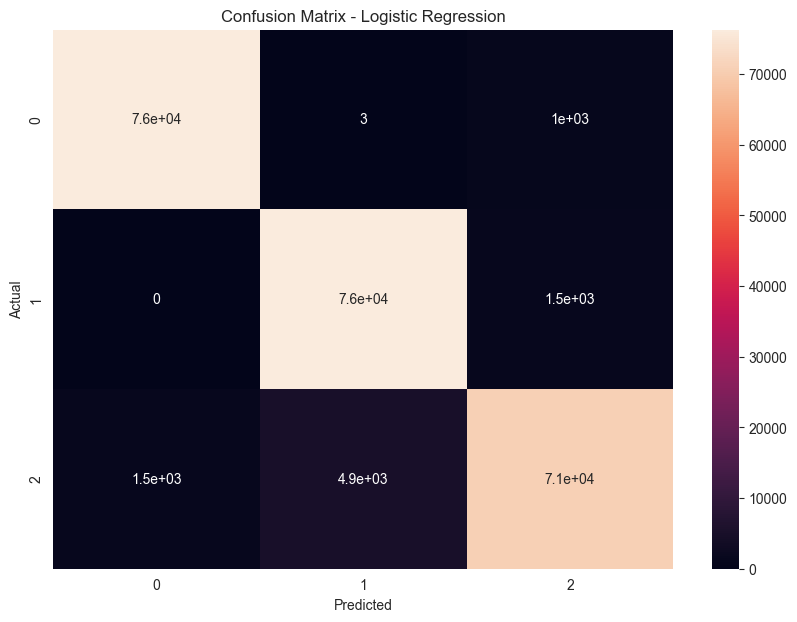

In [9]:
# Drawing Confusing Matrix

cm = confusion_matrix(y_test, model.predict(X_test_pca))

# Plot
plt.figure(figsize = (10,7))
sns.heatmap(cm,annot= True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')

cm


In [10]:
# Saving Model 
import joblib 
joblib.dump(model, "../models/model_version_5.pk1")

['../models/model_version_4.pk1']